# Teilauswertung für Städte mit weniger Messdaten
Christoph Wald, Wiederverwendbar nach MIT-Lizenz

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#function to generate all filenames containing the downloaded data
years = np.arange(2018,2025)
places = ["bruessel", "sofia", "berlin", "paris", "moskau", "stockholm"]

def generate_filenames(years, places):
    for place in places:
        for year in years:
            filename = place + str(year) +".csv"
            yield(filename)

### 2. Datenbereinigung

In [3]:
#Daten aus Datei laden und eine Spalte für "Jahr" hinzufügen
def load_data(place):
    df = pd.read_csv(place+".csv")
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    return df
    
#prozentualen Anteil der Extremwerte anzeigen
def show_extremes(dfs, lower_bound = -20, upper_bound = 40):
    print("Messpunkte mit Temperaturwerten > 40° und < -20°")
    for i in range(3):
        extreme = len(dfs[i][(dfs[i]["temperature_mean"] < lower_bound) | (dfs[i]["temperature_mean"] > upper_bound)])
        all = len(dfs[i])
        
        print(f"{places[i+3]}: {extreme}, entsprechen {100*extreme/all:.2f}%")

In [4]:
#Daten der drei Städte in Liste raw_dfs laden und Extremwerte zeigen
raw_dfs = []
for place in places[3:]:
    print(f"Loading {place}")
    raw_df = load_data(place)
    raw_dfs.append(raw_df)    
show_extremes(raw_dfs)

Loading paris
Loading moskau
Loading stockholm
Messpunkte mit Temperaturwerten > 40° und < -20°
paris: 7763, entsprechen 1.66%
moskau: 9720, entsprechen 1.98%
stockholm: 10883, entsprechen 1.62%


#### 2.1: Unrealistische Extremwerte rausfiltern (damit der Boxplot überhaupt auf den Bildschirm passt) 

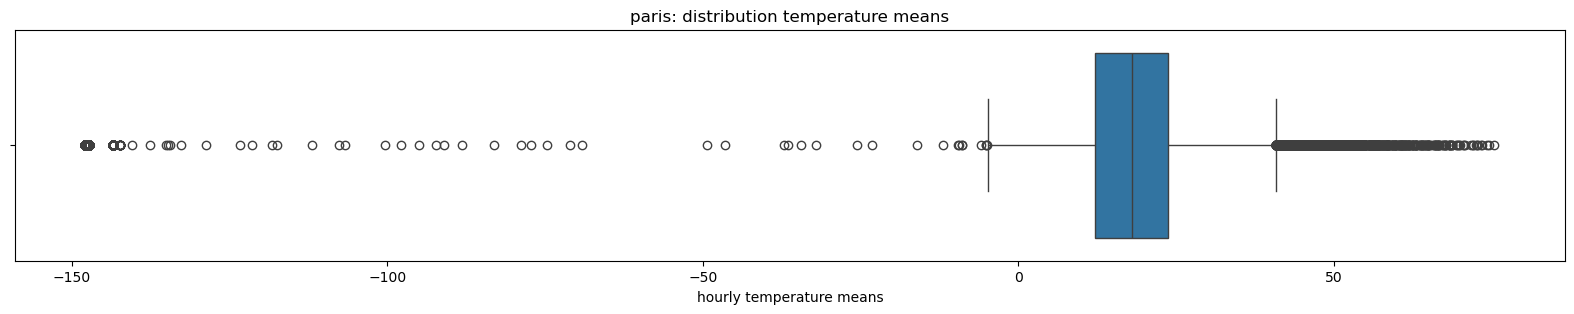

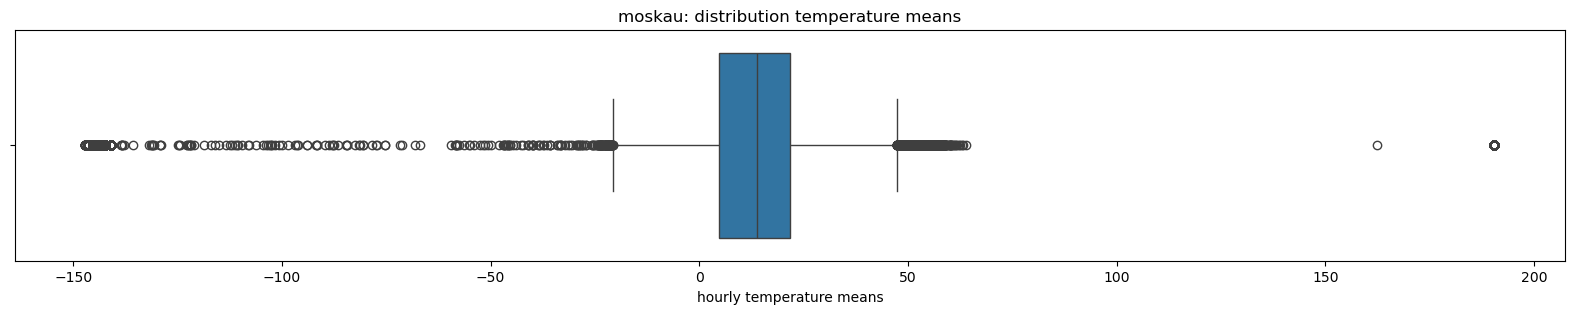

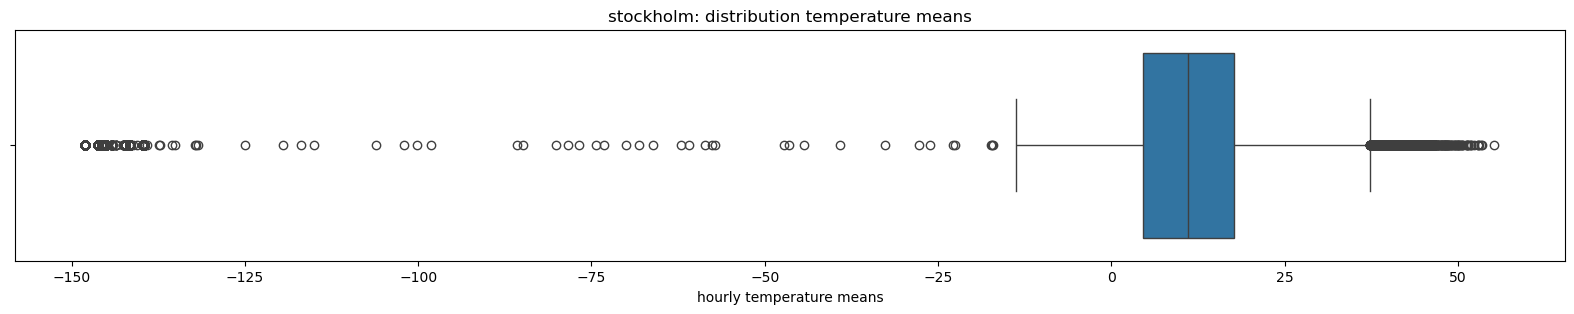

In [5]:
#Boxplot der Datenverteilung
def create_boxplot(df, place):
    plt.figure(figsize=(20,3))
    sns.boxplot(data = df, x="temperature_mean")
    plt.title(place + ": distribution temperature means")
    plt.xlabel("hourly temperature means")
    plt.show()

for i in range(3):
    create_boxplot(raw_dfs[i], places[i+3])

In [6]:
#erstellen einer Liste dfs die keine Messungen mit völlig unrealistischen Werten enthält
#niedrigste gemessene Temperatur: -89.2, höchste gemessene Temperatur: 56.7
dfs = []
for i,df in enumerate(raw_dfs):
    dfs.append(df[(df["temperature_mean"] > -90) & (df["temperature_mean"] < 90 )])
    print(f"{places[i+3]}: filtered out {len(raw_dfs[i]) - len(dfs[i])} datapoints.")
show_extremes(dfs)

paris: filtered out 3818 datapoints.
moskau: filtered out 4193 datapoints.
stockholm: filtered out 10050 datapoints.
Messpunkte mit Temperaturwerten > 40° und < -20°
paris: 3945, entsprechen 0.85%
moskau: 5527, entsprechen 1.14%
stockholm: 833, entsprechen 0.13%


#### 2.2 Outlier-Detection

In [7]:
#Berechnung der outlier, gibt einen Dataframe zurück
def calc_outliers(df, lower = 0.1, upper = 0.9):
    Q1 = df["temperature_mean"].quantile(lower)
    Q3 = df["temperature_mean"].quantile(upper)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Lower Bound: {lower_bound:.2f}")
    print(f"Upper Bound: {upper_bound:.2f}")
    
    return df[(df["temperature_mean"] < lower_bound) | (df["temperature_mean"] > upper_bound)]

#Scatterplot der Outlier
def plot_outliers(outliers, place):
    plt.figure(figsize=(20, 3))
    sns.scatterplot(data=outliers, x="date", y="temperature_mean", hue="sensor_id", palette="Set1", legend=False)
    plt.title(place + ': outliers with color-coded sensors_ids', fontsize=14)
    plt.xlabel('date', fontsize=12)
    plt.ylabel('temperature mean', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#Verteilung von Sensordaten über die Zeit
def plot_bads(bad_sensor, place):
    plt.figure(figsize=(20, 3))
    for sensor_id, group in bad_data.groupby('sensor_id'):
        plt.plot(group['date'], group['temperature_mean'], label=f"Sensor {sensor_id}")
    plt.xlabel('date')
    plt.ylabel('temperature')
    plt.title(place + ': sensor data of really faulty sensors')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

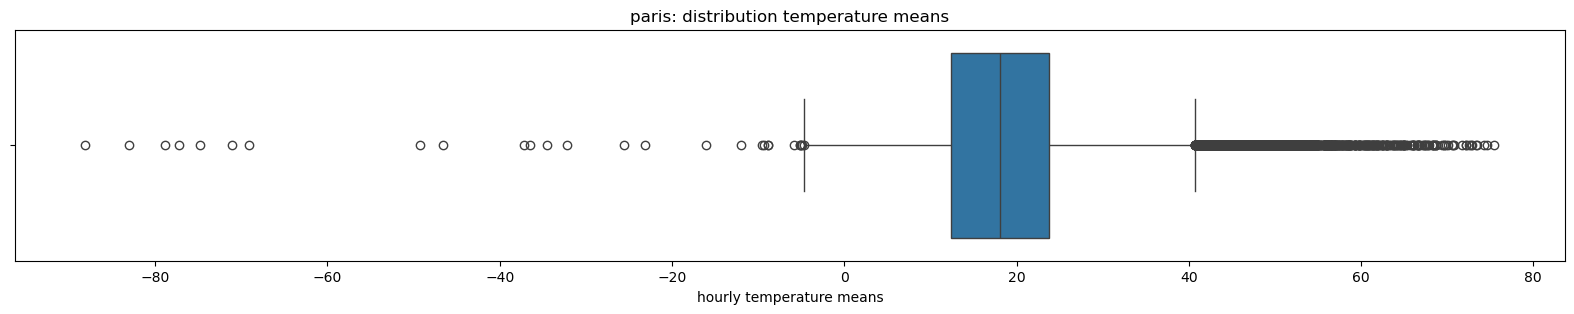

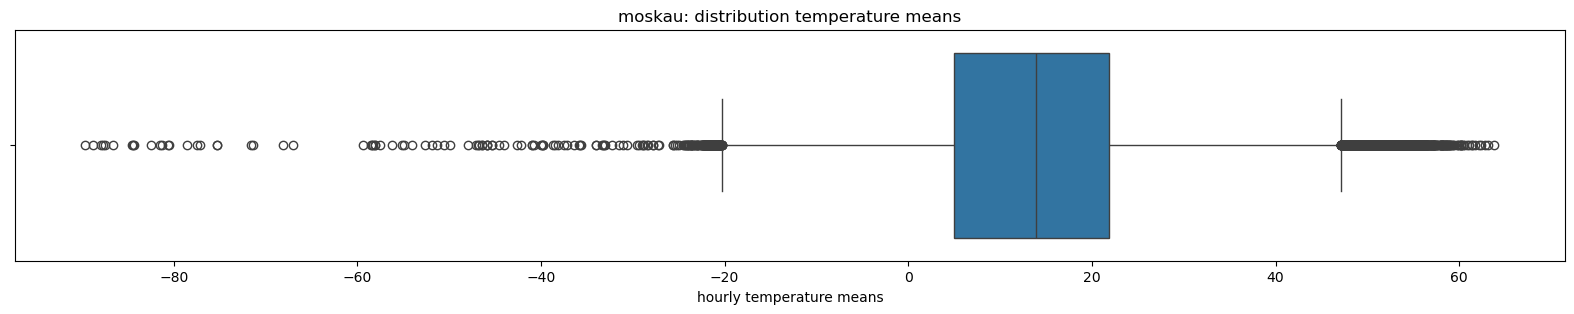

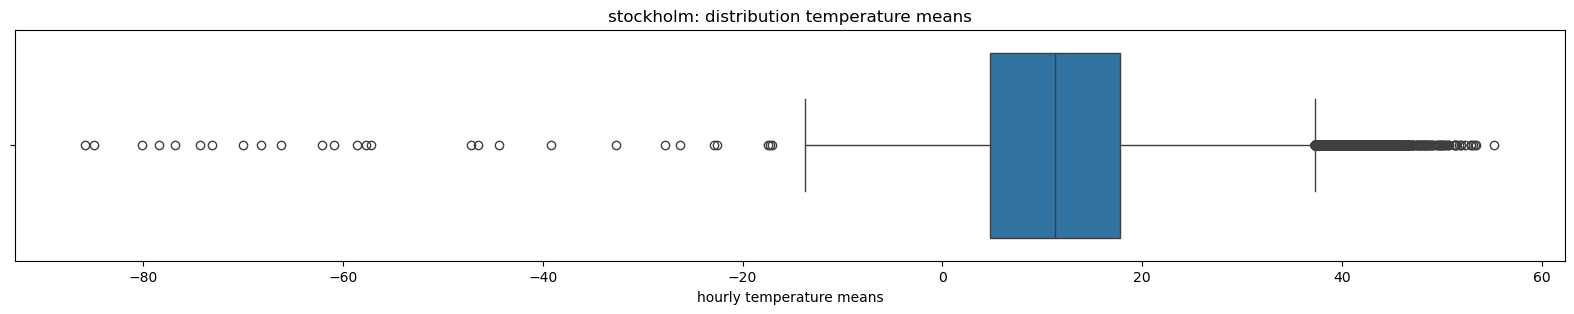

In [8]:
for i in range(3):
    create_boxplot(dfs[i], places[i+3])

In [9]:
#erstellt eine Liste mit den outliern (nach Städten getrennt)
outliers = []
for i in range(3):
    print(places[i+3])
    out = calc_outliers(dfs[i])
    outliers.append(out)
    print(f"{len(out)} outliers detected.")
    print("Unique sensors:", len(out["sensor_id"].unique()))

paris
Lower Bound: -20.10
Upper Bound: 56.25
217 outliers detected.
Unique sensors: 9
moskau
Lower Bound: -41.46
Upper Bound: 67.91
54 outliers detected.
Unique sensors: 7
stockholm
Lower Bound: -31.98
Upper Bound: 55.53
20 outliers detected.
Unique sensors: 10


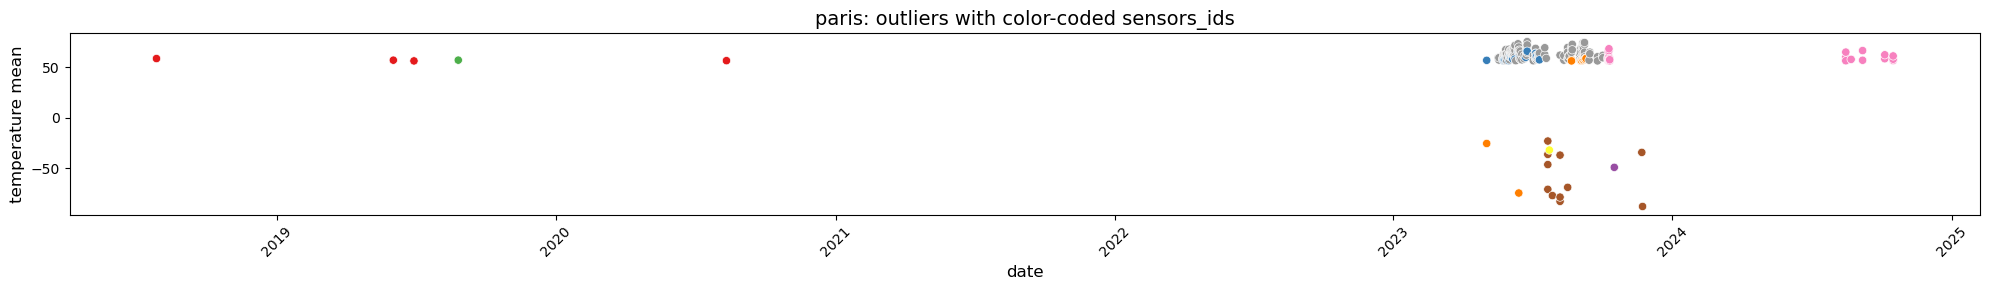

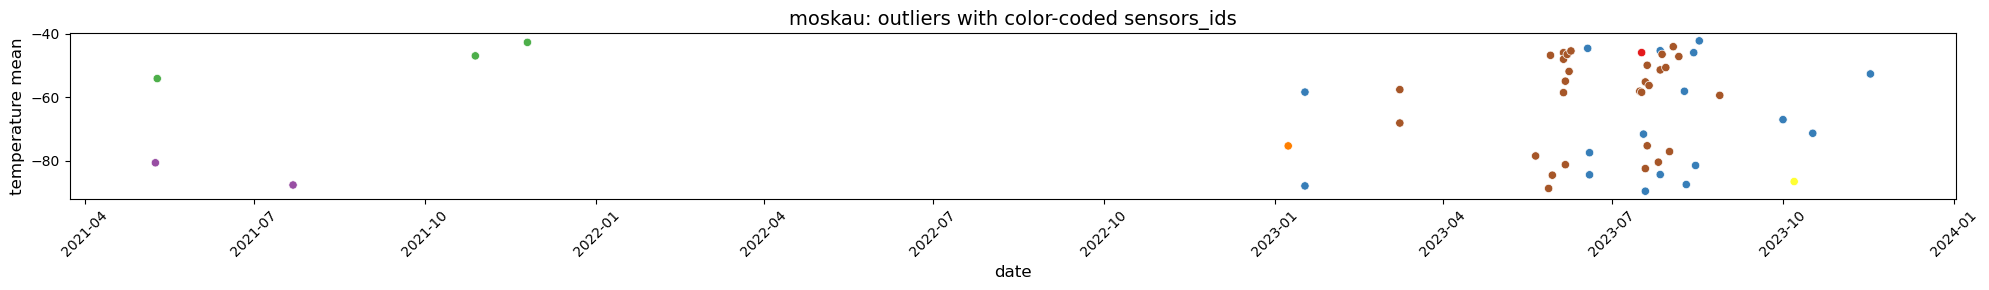

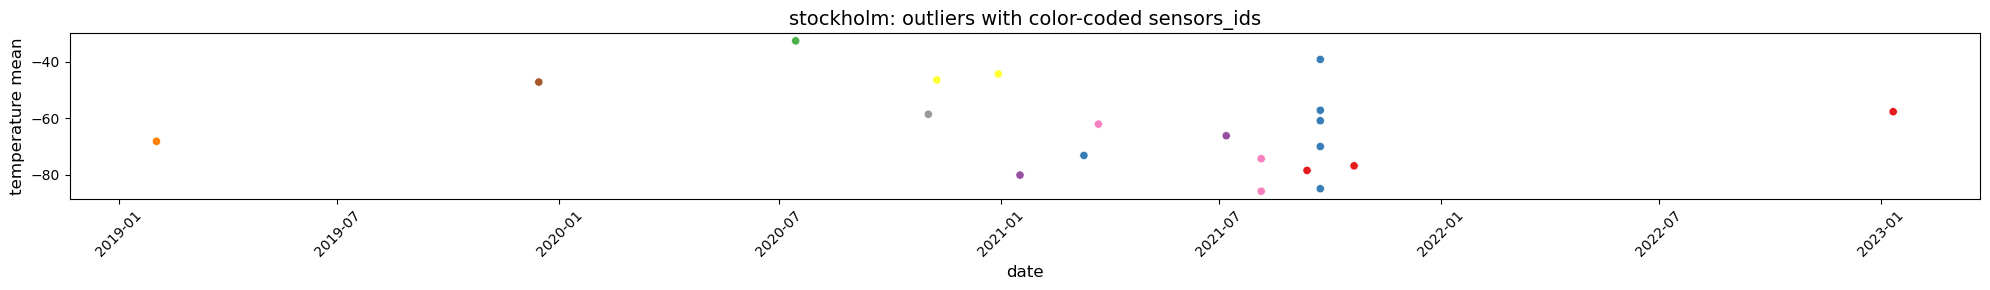

In [10]:
#zeigt die Verteilung der outlier
#farbkodiert, um zu sehen, wieviel einzelne Sensoren beteiligt sind
for i in range(3):
    plot_outliers(outliers[i], places[i+3])

In [11]:
#erstellt eine liste mit sensoren, die mind. 72 mal (3 Tage) in den outliers waren
bad_sensors = []
for out in outliers:
    unique_sensors = out["sensor_id"].unique()
    sensor_entry_counts = pd.DataFrame({
            'sensor_id': unique_sensors,
            'entry_count': [len(out[out.sensor_id == s]) for s in unique_sensors]
        })
    sensor_entry_counts = sensor_entry_counts.sort_values(by='entry_count',ascending = False)
    bad_sensors.append(sensor_entry_counts[sensor_entry_counts["entry_count"] > 72]["sensor_id"].unique())

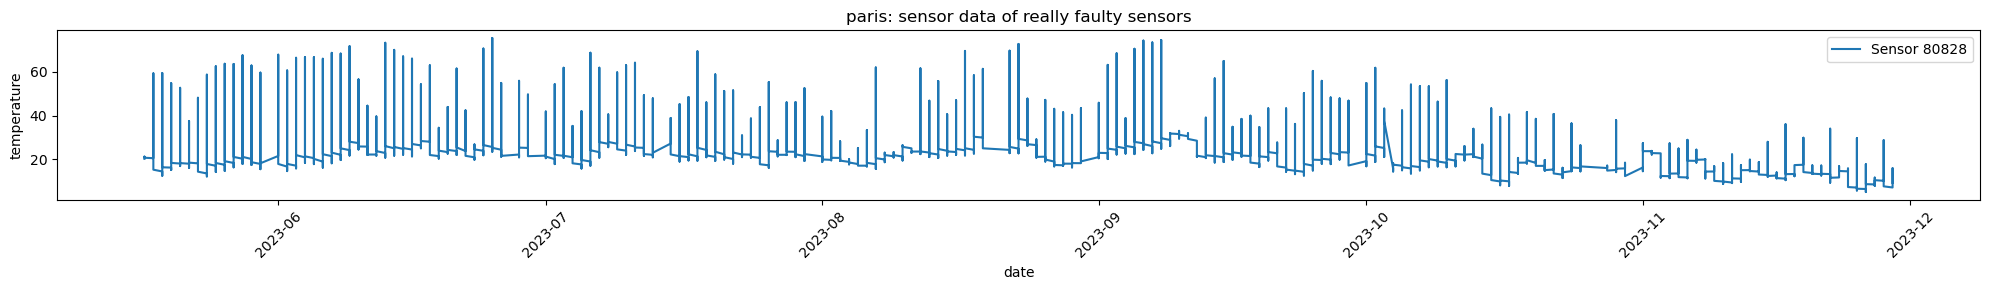

In [12]:
#zeigt die messreihen der betreffenden sensoren
for i in range(3):
    if len(bad_sensors[i]) > 0: 
        bad_data = dfs[i][dfs[i]["sensor_id"].isin(bad_sensors[i])]
        plot_bads(bad_data, places[i+3])


In [13]:
# erstelle eine gefilterte Liste filtered_dfs
filtered_dfs = []
for i in range(3):
    result = dfs[i][~dfs[i].isin(outliers[i].to_dict(orient='list')).all(axis=1)]
    result = result[~result["sensor_id"].isin(bad_sensors[i])]
    filtered_dfs.append(result)
    

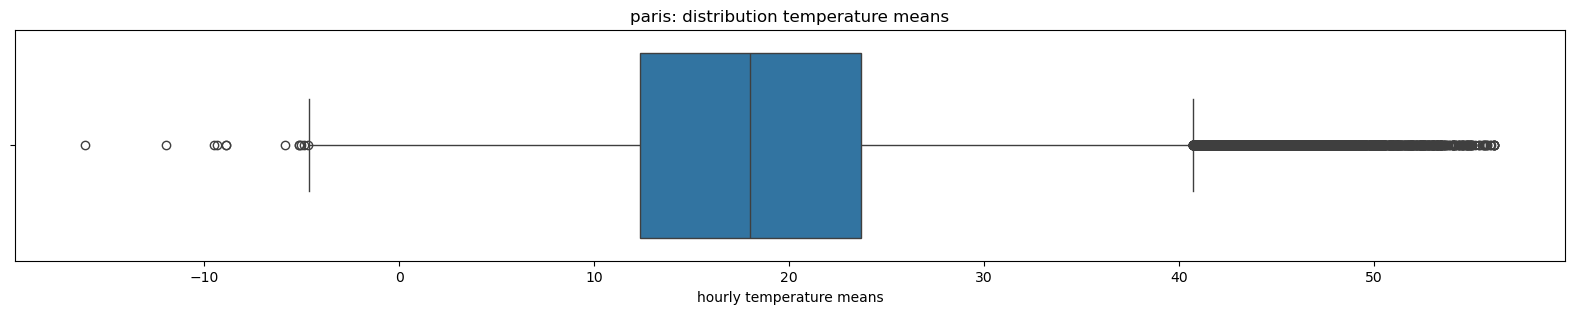

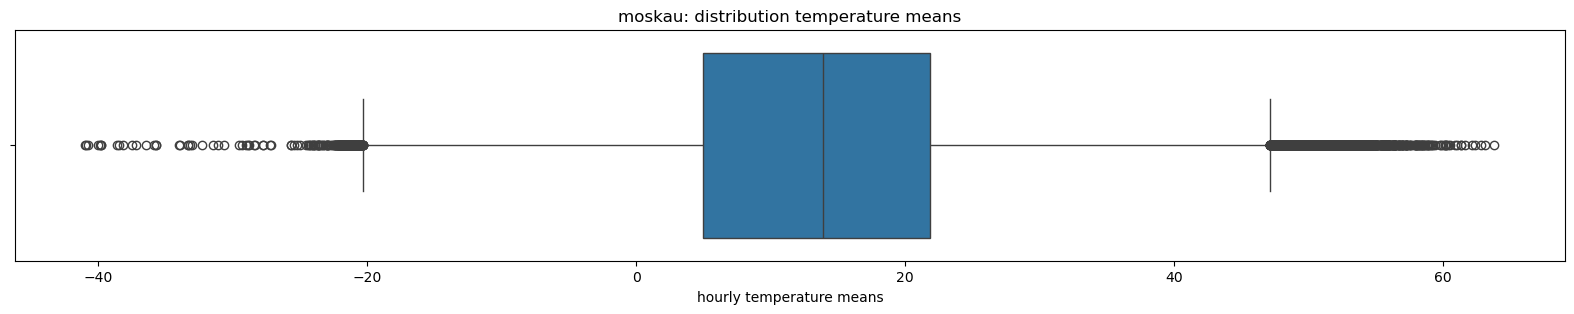

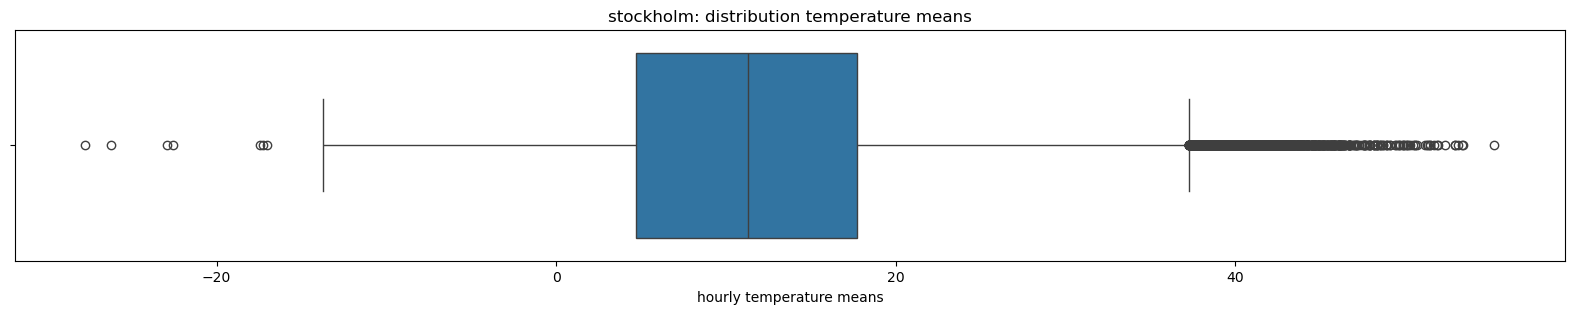

In [14]:
for i in range(3):
    create_boxplot(filtered_dfs[i], places[i+3])

In [15]:
show_extremes(filtered_dfs)

Messpunkte mit Temperaturwerten > 40° und < -20°
paris: 3469, entsprechen 0.75%
moskau: 5473, entsprechen 1.13%
stockholm: 813, entsprechen 0.12%


### 3. Auswertung

#### 3.1 Erster Überblick: Tägliche Mittelwerte


In [16]:
def calc_daily_means(df):
    return df.groupby(['year', 'date'])['temperature_mean'].mean().reset_index()

def plot_overview(df, place):
    plt.figure(figsize=(20,3))
    for i, year in enumerate(years):
        year_data = df[df['year'] == year]
        plt.plot(year_data['date'], year_data['temperature_mean'], label=str(year))
    plt.xlabel('daily means')
    plt.ylabel('mean temperature')
    plt.title(place + " sequential")
    plt.legend()
    plt.show()
    plt.figure(figsize=(20,3))
    for year in years:
        year_data = df[df['year'] == year]
        day_of_year = year_data['date'].dt.dayofyear
        plt.plot(day_of_year, year_data['temperature_mean'], label=str(year))
    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mean temperature')
    plt.xlim(1, 366)  # Schaltjahre
    plt.title(place + " year")
    plt.show()

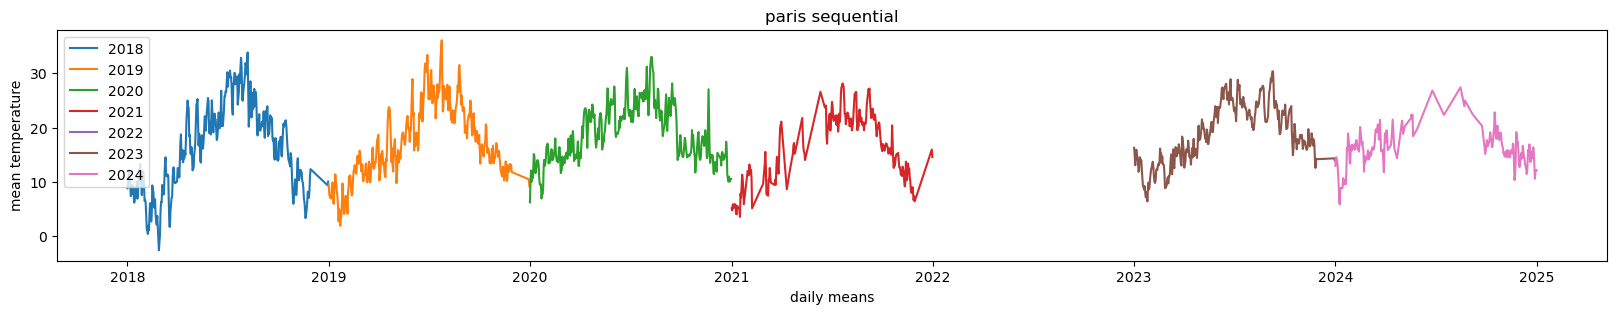

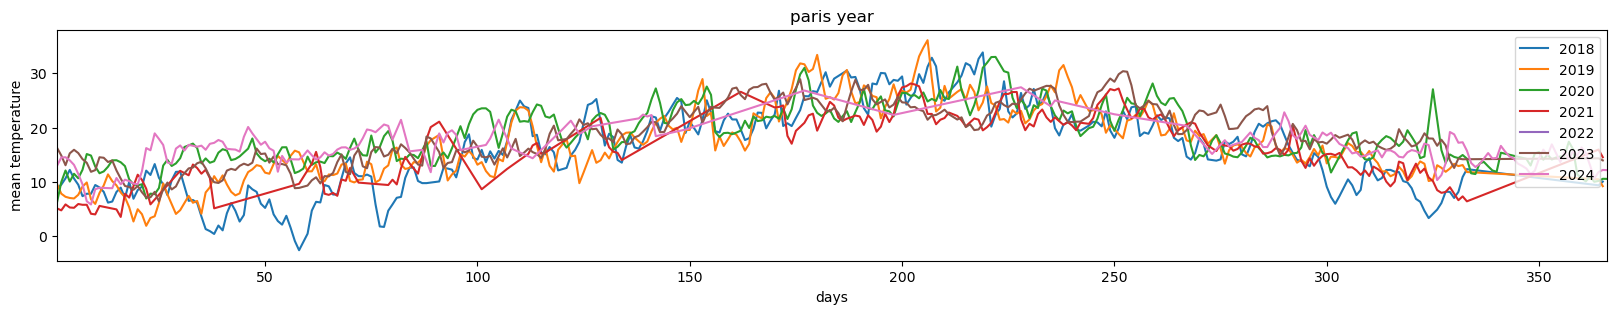

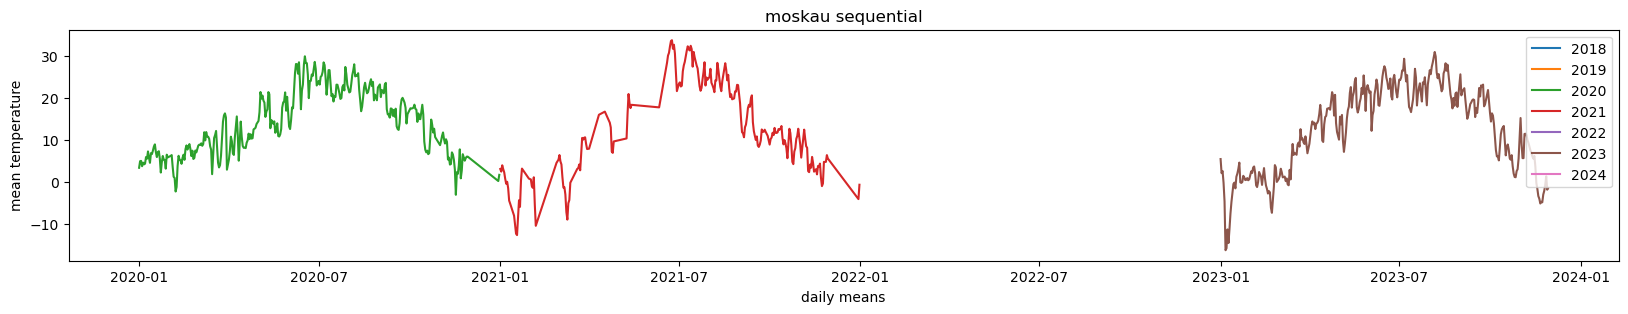

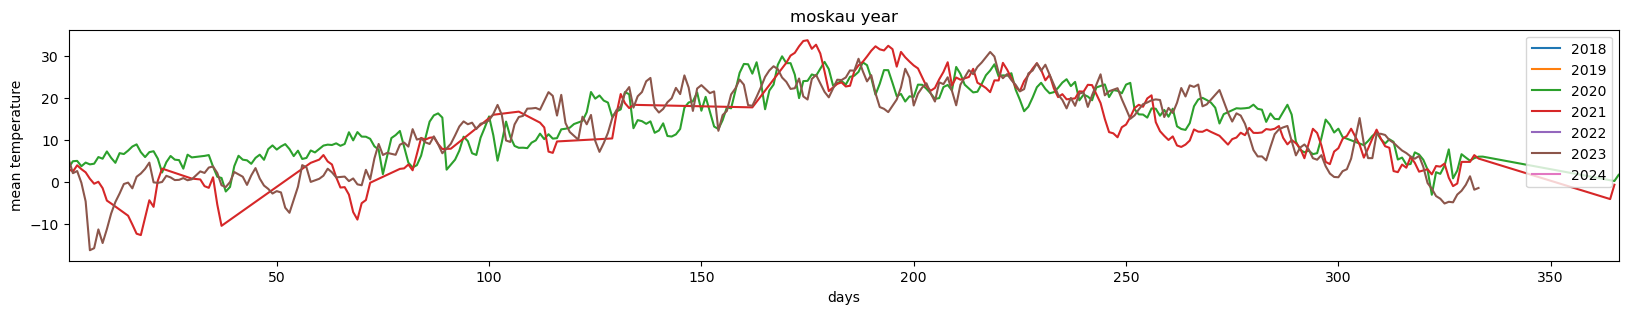

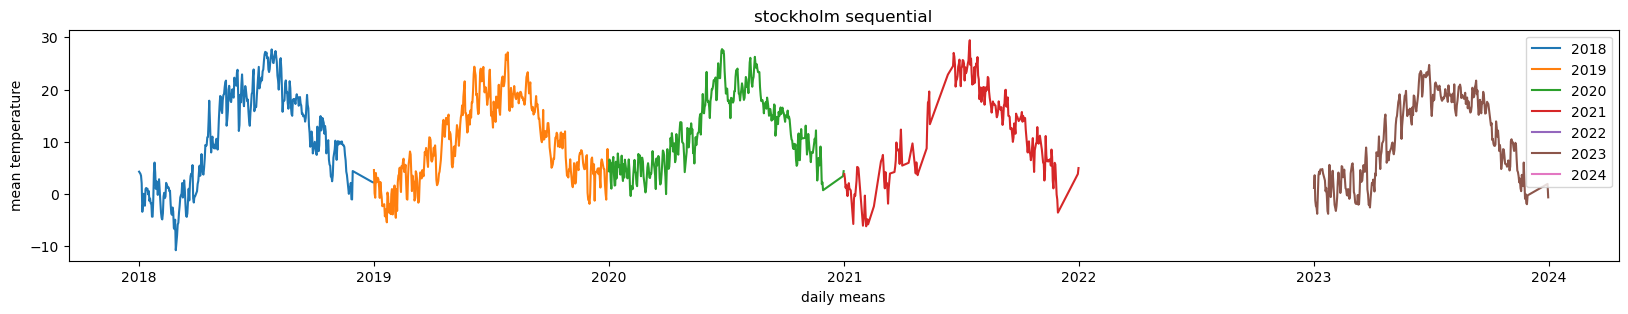

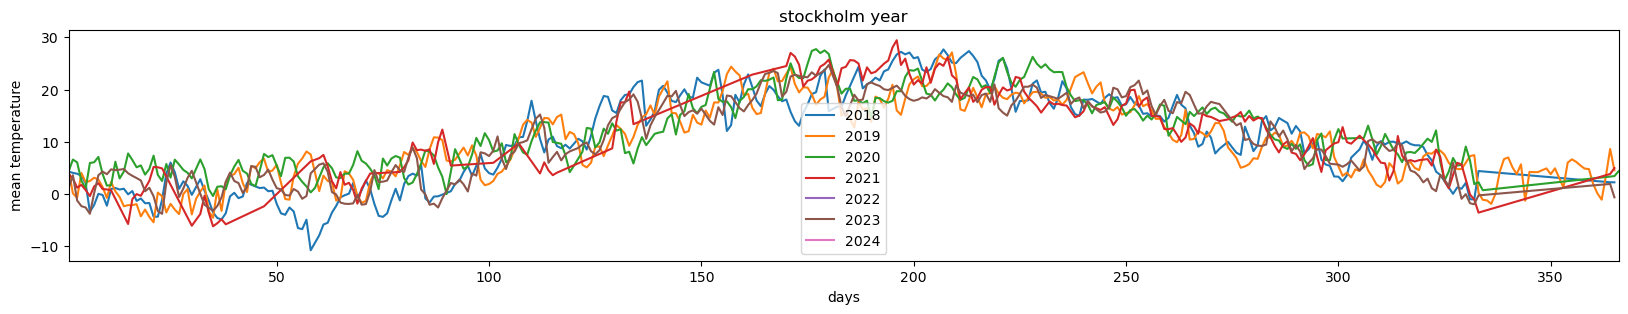

In [17]:
for i in range(3):
    daily_means = calc_daily_means(filtered_dfs[i])
    plot_overview(daily_means, places[i+3])

#### 3.2 Jährliche Mittelwerte

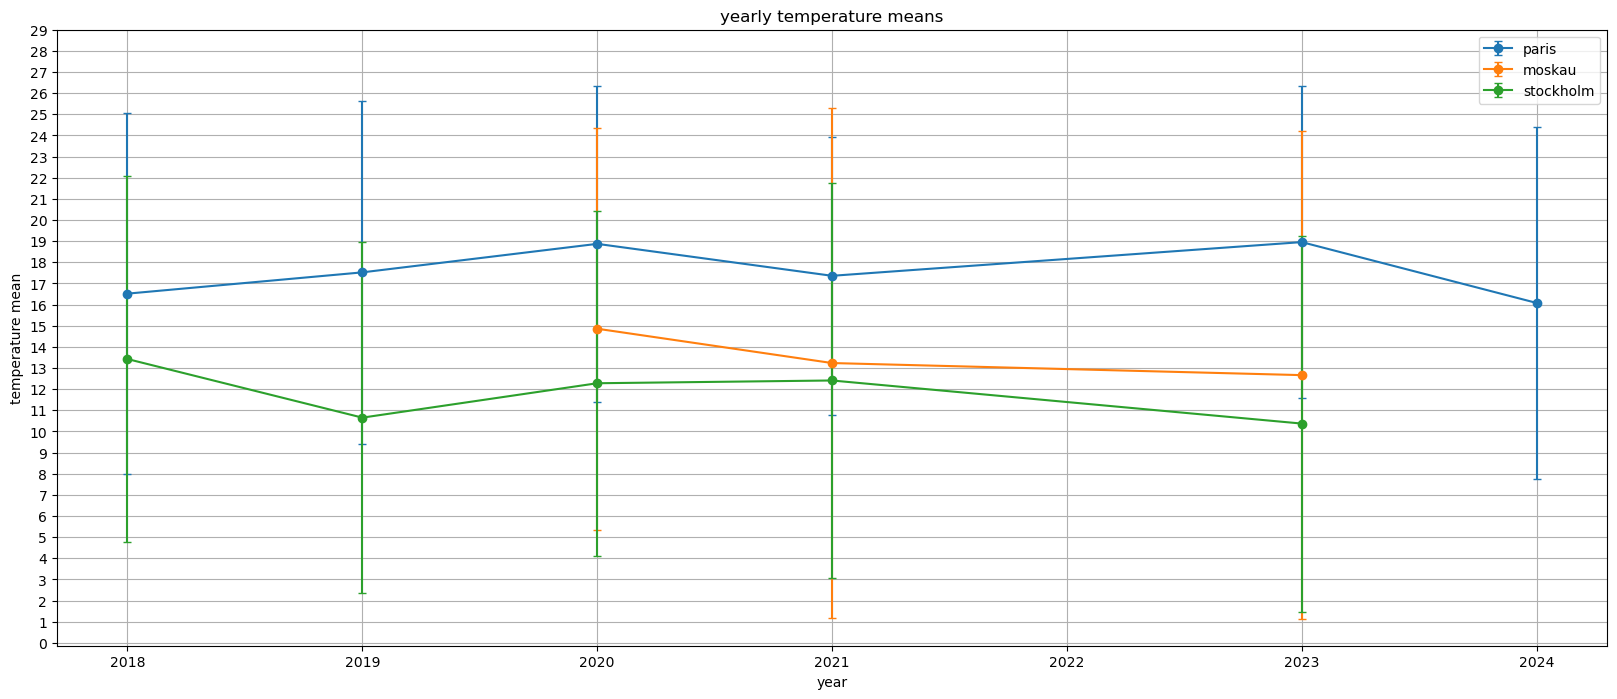

In [18]:
plt.figure(figsize=(20,8))
for i in range(3):
    
    yearly_means = filtered_dfs[i].groupby(['year'])['temperature_mean'].agg(['mean', 'std']).reset_index()
    
    plt.errorbar(
        yearly_means["year"], 
        yearly_means["mean"], 
        yerr=yearly_means["std"], 
        label=places[i+3], 
        capsize=3,  
        fmt='-o'   
    )
plt.yticks(np.arange(0,30))

plt.grid(visible = True)
plt.legend()
plt.xlabel("year")
plt.ylabel("temperature mean")
plt.title("yearly temperature means")
plt.show()


#### Vgl. für diesen und den folgenden Graph das notebook für die Städte mit weniger Messdaten.

#### 3.3 Monatliche Mittelwerte

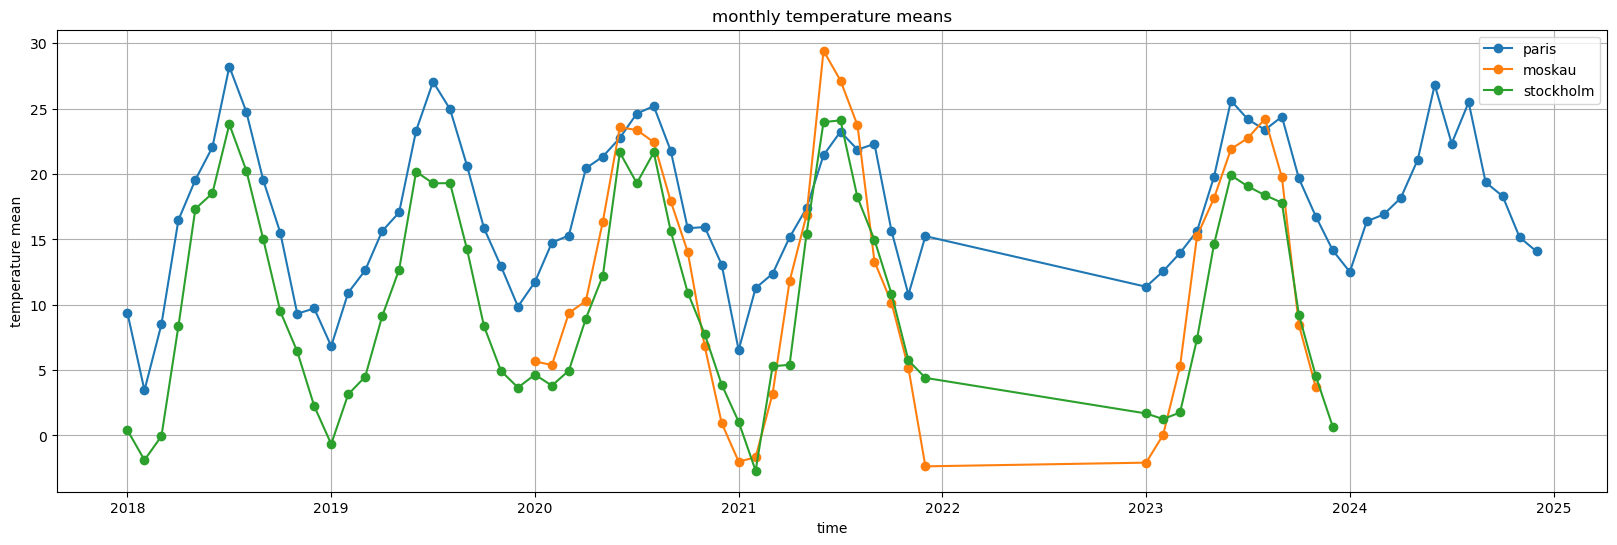

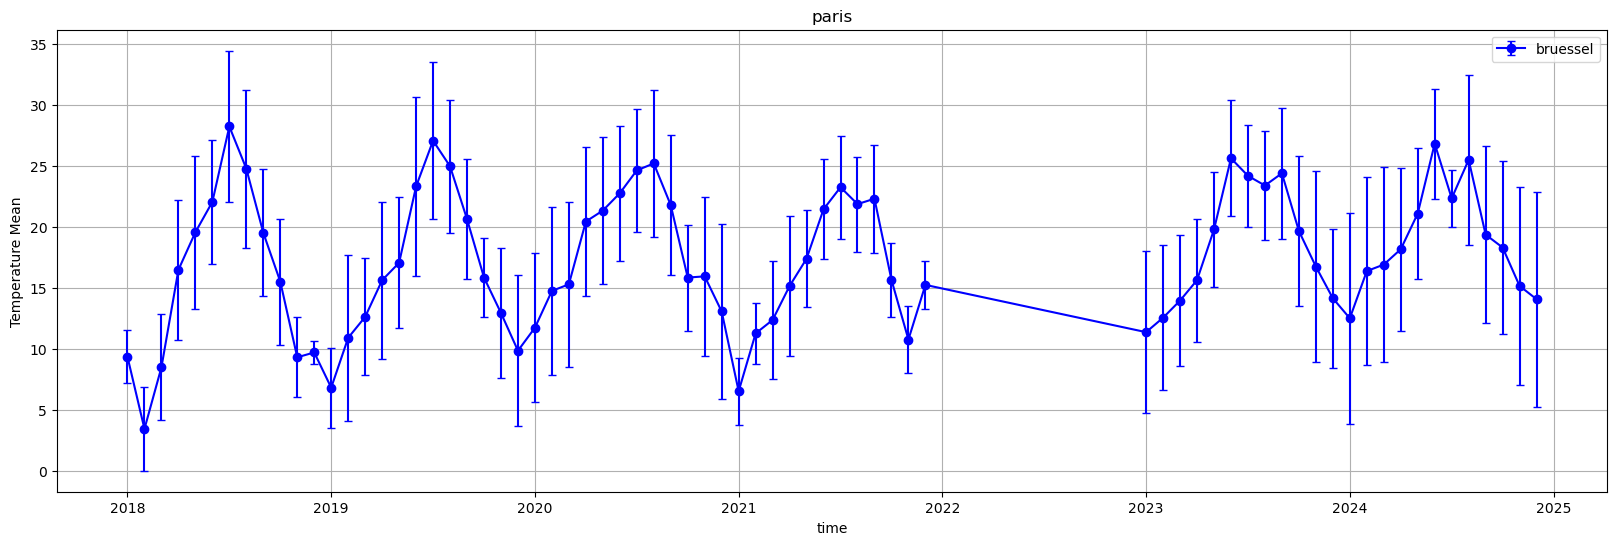

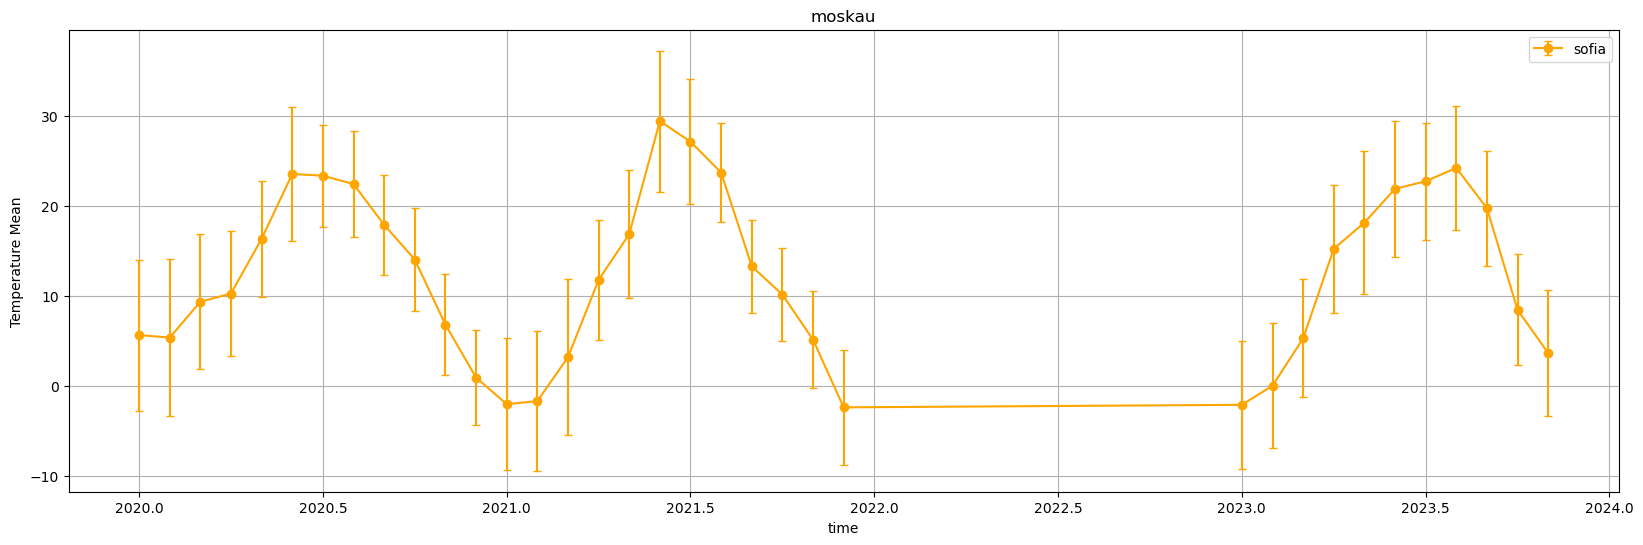

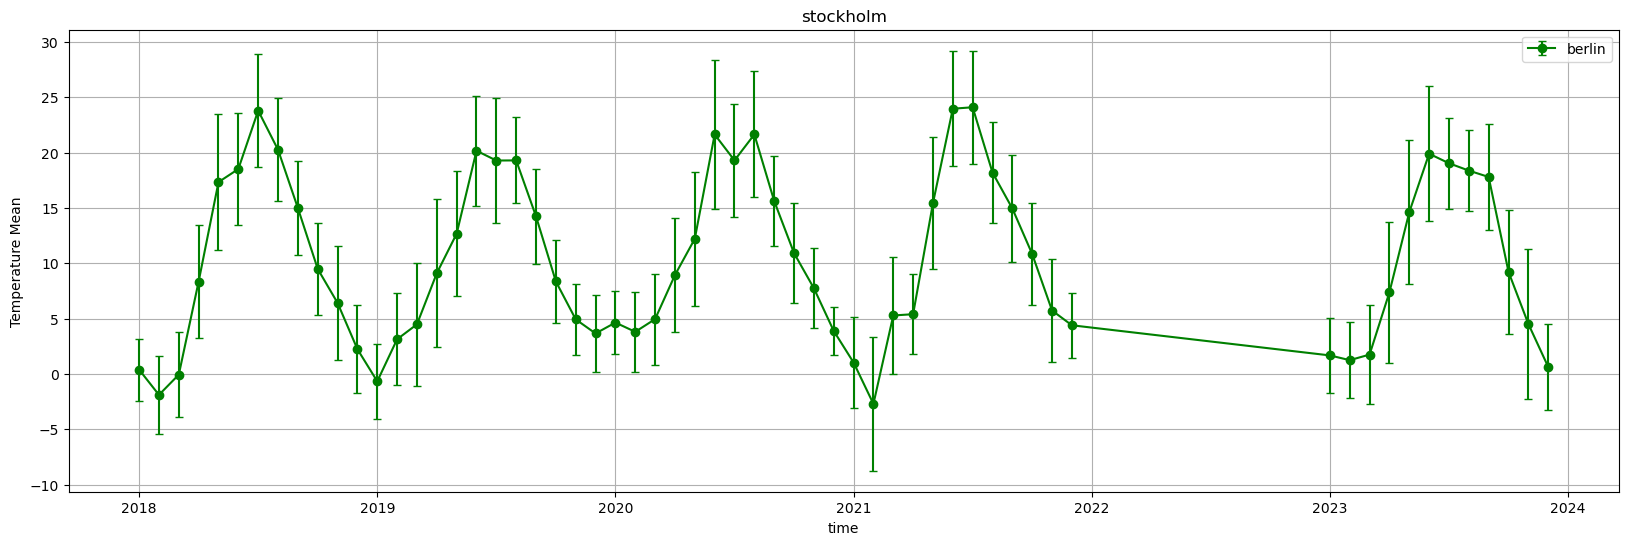

In [19]:
#eine Spalte für die Monate ergänzen
for i in range(3):
    filtered_dfs[i]['date'] = pd.to_datetime(filtered_dfs[i]['date'])  
    filtered_dfs[i]['month'] = filtered_dfs[i]['date'].dt.month       

# monatliche Mittel alle drei Städte
plt.figure(figsize = (20,6))
plt.grid(visible = True)
for i in range(3):

    stats = filtered_dfs[i].groupby(['year', 'month'])['temperature_mean'].agg(['mean', 'std']).reset_index()
    stats['year_month'] = stats['year'] + (stats['month'] - 1) / 12
    plt.plot(
        stats["year_month"], 
        stats["mean"],  
        label=places[i+3],
        marker = 'o'
    )
plt.legend()
plt.xlabel("time")
plt.ylabel("temperature mean")
plt.title("monthly temperature means")
plt.show()

#Städe einzeln
colors = ["blue", "orange", "green"]
for i in range(3):
    plt.figure(figsize = (20,6))
    plt.grid(visible = True)
    
    stats = filtered_dfs[i].groupby(['year', 'month'])['temperature_mean'].agg(['mean', 'std']).reset_index()
    stats['year_month'] = stats['year'] + (stats['month'] - 1) / 12

    plt.errorbar(
        stats["year_month"], 
        stats["mean"], 
        yerr=stats["std"], 
        label=places[i], 
        capsize=3, 
        fmt='-o',
        c = colors[i]
    )

    plt.legend()
    plt.xlabel("time")
    plt.ylabel("Temperature Mean")
    plt.title(places[i+3])
    plt.show()
